In [23]:
!unzip -o .data/*.zip -d .data

Archive:  .data/drive-download-20210519T172133Z-001.zip
  inflating: .data/2021_05_19 20_03 Office Lens.jpg  
  inflating: .data/IMG_20210519_200224.jpg  
  inflating: .data/IMG_20210519_200214.jpg  
  inflating: .data/IMG_20210519_200158.jpg  
  inflating: .data/IMG_20210519_200151.jpg  
  inflating: .data/IMG_20210519_200206.jpg  
  inflating: .data/IMG_20210519_200147.jpg  
  inflating: .data/IMG_20210519_200231.jpg  


In [29]:
!ls .data

'2021_05_19 20_03 Office Lens.jpg'	   IMG_20210519_200206.jpg
 drive-download-20210519T172133Z-001.zip   IMG_20210519_200214.jpg
 IMG_20210519_200147.jpg		   IMG_20210519_200224.jpg
 IMG_20210519_200151.jpg		   IMG_20210519_200231.jpg
 IMG_20210519_200158.jpg


In [150]:
import os

import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision

torch.__version__

'1.7.0+cu101'

In [192]:
def load_images(path):
    file_names = [f for f in os.listdir(path) if f.endswith('jpg')]
    imgs = []
    scale = 0.2
    h, w = int(2997 * scale), int(2138 * scale)
    for file_name in file_names:
        im_path = os.path.join(path, file_name)
        img = cv2.imread(im_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (w, h))
        imgs.append(img / 255)
        
    return torch.tensor(imgs, dtype=torch.float32)

In [193]:
imgs = load_images('.data')

In [194]:
y = imgs[1]
x = imgs[4]

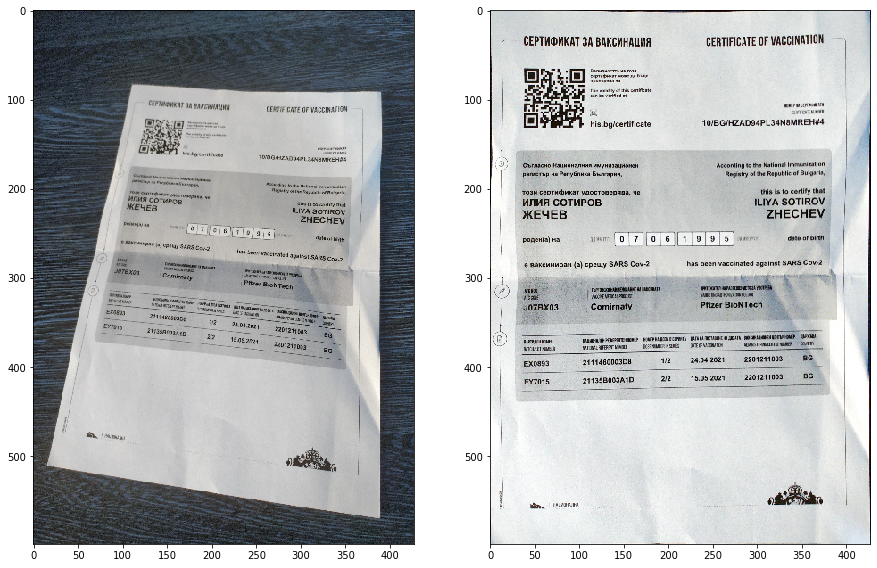

In [195]:
fig = plt.figure(figsize=(15, 15))
ax1, ax2 = fig.subplots(1, 2)

ax1.imshow(x)
ax2.imshow(y)

In [196]:
x.shape

torch.Size([599, 427, 3])

In [197]:
class Reshape(nn.Module):
    def __init__(self, *shape):
        super().__init__()
        self.shape = shape

    def forward(self, x):
        return x.reshape(self.shape)

In [198]:
class Lambda(nn.Module):
    def __init__(self, handler):
        super().__init__()
        self.handler = handler

    def forward(self, x):
        return self.handler(x)

In [624]:
class SpatialTransformer(nn.Module):
    def __init__(self, i, num_channels, only_translations=False):
        super().__init__()

        self.only_translations = only_translations
        self.num_channels = num_channels
        self.locator = nn.Sequential(
            nn.Linear(i, num_channels * 2 * 3),
            Reshape(-1, 2, 3),
        )

        self.device = self.locator[0].bias.device
        # Taken from the pytorch spatial transformer tutorial.
        self.locator[0].weight.data.zero_()
        self.locator[0].bias.data.copy_(
            torch.tensor(
                [1, 0, 0, 0, 1, 0] * num_channels,
                dtype=torch.float,
            ).to(self.device))

    def forward(self, x):
        inp, tensor_3d = x
        device = inp.device

        theta = self.locator(inp)
        _, C, H, W, = tensor_3d.shape

        if self.only_translations:
            theta[:, :, :-1] = torch.tensor(
                [[1, 0], [0, 1]],
                dtype=torch.float,
            ).to(device).unsqueeze_(0)

        grid = F.affine_grid(
            theta,
            (theta.size(dim=0), 1, H, W),
            align_corners=True,
        )

        tensor_3d = tensor_3d.reshape(-1, 1, H, W)
        tensor_3d = F.grid_sample(
            tensor_3d,
            grid,
            align_corners=True,
        )

        return tensor_3d.reshape(-1, C, H, W)

In [625]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.norm = Lambda(lambda x: x.permute(2, 0, 1).unsqueeze(0))
        self.feature_extractor = torchvision.models.resnet34()
        self.st = SpatialTransformer(1000, num_channels=1)
        
    def forward(self, x):
        x = self.norm(x)
        self.features = self.feature_extractor(x)
        y_hat = self.st([self.features, x[:, :1]])
        return y_hat
    
    def criterion(self, y_hat, y):
        y = self.norm(y)[:, :1]
        return F.binary_cross_entropy(y_hat, y)
    
    def optim_step(self, optim, batch):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        
        if loss.requires_grad:
            optim.zero_grad()
            loss.backward()
            optim.step()
            
        return {
            'loss': loss.item(),
            'features': self.features,
            'y_hat': y_hat,
        }

In [626]:
from IPython.display import display, clear_output

class Fig:
    def __init__(self, nr, nc, *args, **kwargs):
        self.fig = plt.figure(*args, **kwargs)
        self.axs = self.fig.subplots(nr, nc)
        self.called = set()
    
    def __getitem__(self, index):
        ax = self.axs[index] if hasattr(self.axs, '__getitem__') else self.axs
        
        def set_data(child, data):
            try:
                child.set_array(data.ravel())
            except:
                try:
                    child.set_data(*data)
                except:
                    pass
                
        def create_plot(key, identifier, data, kwargs):
            self.called.add(key)
            try:
                getattr(sns, identifier)(*data, **kwargs, ax=ax)
            except:
                try:
                    getattr(ax, identifier)(*data, **kwargs)
                except:
                    pass

        class Getattr:
            def __getattr__(_, identifier):
                key = identifier, index

                class Call:
                    def __call__(_, data, **kwargs):
                        if key in self.called:
                            for child in ax.get_children():
                                    set_data(child, data)
                        else:
                            create_plot(key, identifier, data, kwargs)

                return Call()

        return Getattr()
    
    def display(self):
        display(self.fig)
        return self
        
    def clear(self):
        clear_output(wait=True)
        return self
        
    def update(self):
        self.clear()
        self.display()

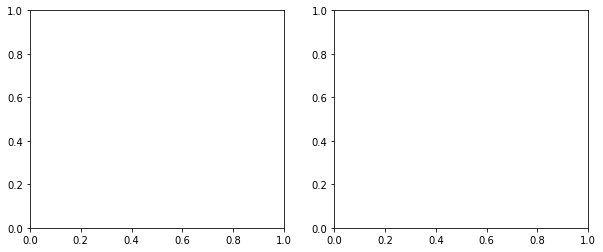

In [627]:
f = Fig(1, 2, figsize=(10, 4)).clear()

In [660]:
import time

for _ in range(30):
    time.sleep(1)
    r = np.random.rand(1000, 1000)
    f[0].imshow(r)
    time.sleep(1)
    r = np.random.rand(100, 100)
    f[1].imshow(r)
    
    f.update()

KeyboardInterrupt: 

In [708]:
model = Model()
optim = torch.optim.Adam(model.parameters(), lr=0.001)

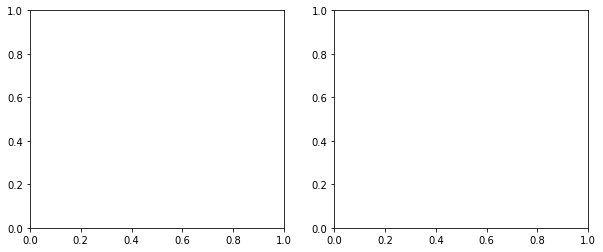

In [709]:
f = Fig(1, 2, figsize=(10, 4)).clear()

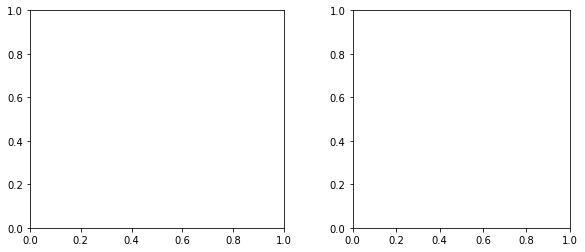

In [711]:
DEVICE = 'cpu'
model = model.to(DEVICE)

for i in range(10):
    optim_info = model.optim_step(optim, [x.to(DEVICE), y.to(DEVICE)])
    features = optim_info['features'].detach().cpu()
    img = optim_info['y_hat'].detach().cpu()[0, 0]
    
    f[0].lineplot(data=(range(100), features))
    f[1].imshow(data=(img,))

    f.update()

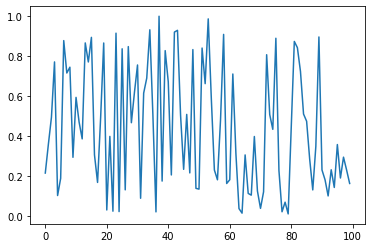

In [702]:
plt.plot(range(100), np.random.rand(100))

In [ ]:
for 

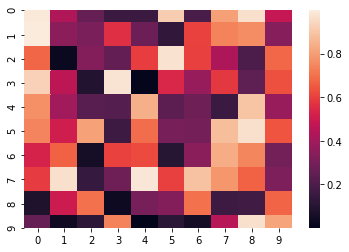

In [336]:
sns.heatmap(np.random.rand(10, 10))